In [1]:
from dataloader import *
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
files = DataAnuncis('/home/adri/Desktop/cvc/data/tinder-historic/filenames.txt')


In [3]:
sample = files[0]

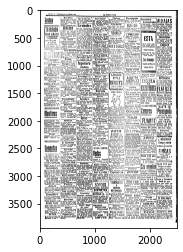

In [4]:
plt.imshow(sample, cmap = 'gray')
plt.show()

In [5]:
ret, thresh = cv2.threshold(sample, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)


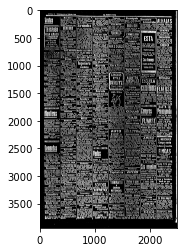

In [6]:
plt.imshow(thresh, cmap = 'gray')
plt.show()

In [7]:
cols = thresh.shape[1]
horizontal_size = cols // 30
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
horizontal = cv2.erode(thresh, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)

In [8]:
# Specify size on vertical axis
rows = thresh.shape[0]
verticalsize = rows // 30
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
# Apply morphology operations
vertical = cv2.erode(thresh, verticalStructure)
vertical = cv2.dilate(vertical, verticalStructure)

In [9]:
%matplotlib qt
plt.imshow(vertical*.5 + horizontal*.5, cmap = 'gray')
plt.show()

In [10]:
anuncis = vertical*.5 + horizontal*.5 # What will we do when the blocks arent delimited by lines
anuncis = ((anuncis - anuncis.min()) / (anuncis.max() - anuncis.min())) * 255
ret, anuncis = cv2.threshold(anuncis.astype(np.uint8), 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
plt.imshow(anuncis, cmap = 'gray')
plt.show()

In [11]:
plt.imshow(anuncis, cmap = 'gray')
plt.show()

In [12]:
contours, hierarchy = cv2.findContours(anuncis, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

269


In [13]:
sample2 = sample.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    # Drawing a rectangle on copied image
    sample2 = cv2.rectangle(sample2, (x, y), (x + w, y + h), (0, 255, 0), 20)

In [14]:
%matplotlib qt
plt.imshow(sample2, cmap = 'gray')
plt.show()